In [1]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split

# Summary-like from Tensorflow
from torchsummary import summary

# Import Numpy
import numpy as np
# Plot Import
import matplotlib.pyplot as plt
# For timer
import time
# Import OS
import os
# import local libs
import ecg_tools_lite as et

from statistics import mean

# WFDB
import wfdb

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

In [2]:
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')

print("Device:", device, time.localtime().tm_mon, "/", time.localtime().tm_mday, "/", time.localtime().tm_year)
device

Device: cuda 11 / 30 / 2020


device(type='cuda')

In [61]:
# =============== LOAD ECG DATA ===============
# Load numpy version datasets
# ecg_clean = et.load_ecg_file('all_chunks_fs1024_e24.npy')
# ecg_noisy = et.load_ecg_file('all_chunks_fs1024_e06.npy')
ecg_noisy_06, ecg_clean_06 = et.get_ecg_with_split('118e06', samp_freq=1024, norm_type='chunks')
ecg_noisy_24, ecg_clean_24 = et.get_ecg_with_split('118e24', samp_freq=1024, norm_type='chunks')
# Load datasets to CUDA
ecg_noisy = torch.from_numpy(ecg_noisy_06).double() #.to(device)
ecg_clean = torch.from_numpy(ecg_clean_06).double() #.to(device)

# Create train and validation datasets
train_size = int( (ecg_clean.shape[0])*.80 ) # Get 80%
val_size = int( (ecg_clean.shape[0])*.20 ) # Get 20%

# Use this for checking
total_size = train_size + val_size
if total_size < ecg_noisy.shape[0]:
    train_size = train_size + (ecg_noisy.shape[0] - total_size)

# Split datasets into train and validation
train_dataset, val_dataset = random_split( ecg_noisy, (train_size, val_size) )

# Create a data loader for both datasets
train_loader = DataLoader( train_dataset, shuffle=True, batch_size=1)
val_loader = DataLoader( val_dataset, shuffle=True, batch_size=1)
# Preview the shape of the train_loader
print( f"When train_loader is called, the entire shape is: {len(train_loader)}, 1024, 1" )
print( f"When val_loader is called, the entire shape is: {len(val_loader)}, 1024, 1" )
print( f"Total size: {total_size} = {train_size} + {val_size}" )

When train_loader is called, the entire shape is: 101, 1024, 1
When val_loader is called, the entire shape is: 25, 1024, 1
Total size: 125 = 101 + 25


In [38]:
# Well instead of having to randomize the data itself, why not the numbers used to index
index_set = np.arange(0, total_size+1)
train_indexset, val_indexset = random_split( index_set, (train_size, val_size))
traindex_loader = DataLoader( train_indexset, shuffle=True, batch_size=1 )
valdex_loader = DataLoader( val_indexset, shuffle=True, batch_size=1 )

0
Shape: torch.Size([1, 1024, 1])


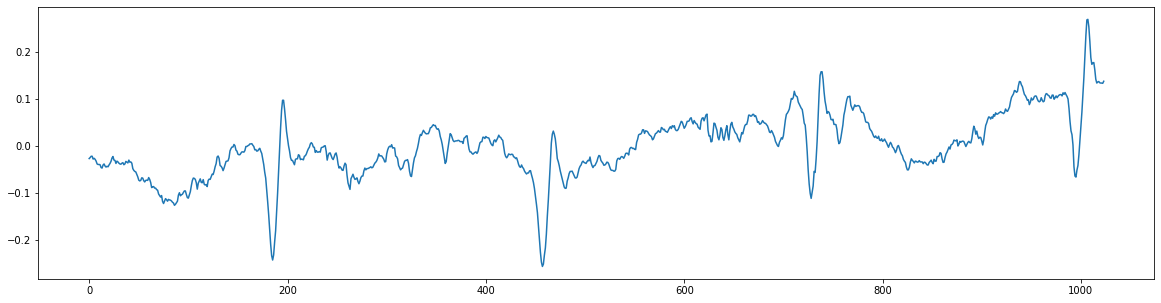

In [4]:
# If we look at how DataLoader works, we will get a random data everytime it is called thus, 
# running the lines below will result into a different ECG data
for i, data in enumerate( train_loader ):
    print( i )
    if i == 0:
        print(f'Shape: {data.shape}')
        x = data.cpu().numpy()
        plt.figure( figsize=(20,5) )
        plt.plot( x[0][:] )
        break

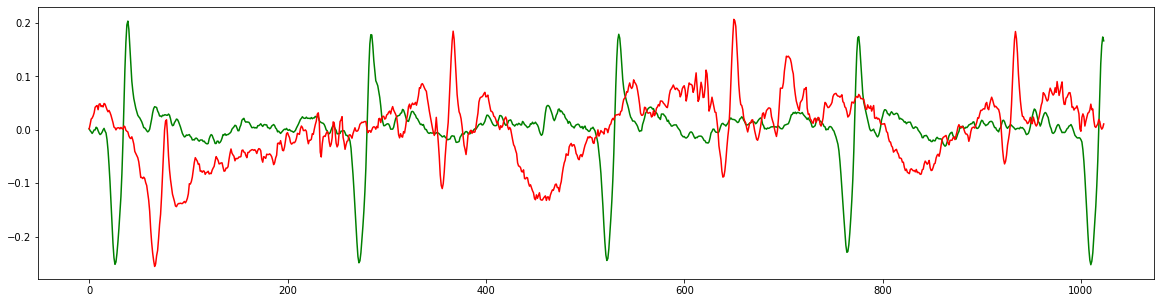

In [58]:
# for i, data in enumerate( traindex_loader ):
#     print( f'{i} contains {data.cpu().numpy()[0]}' )
#     if i == 0:
#         x = data.cpu().numpy()[0]
#         print( f'{x} and {x}' )
#         samp_clean = ecg_clean[x].cpu()
#         samp_noisy = ecg_noisy[x].cpu()
#         plt.figure( figsize=(20,5) )
#         plt.plot( samp_clean, c='green' )
#         plt.plot( samp_noisy, c='red' )
#         break
index = 1
plt.figure( figsize=(20,5) )
plt.plot( ecg_clean[index].cpu(), c='green' )
plt.plot( ecg_noisy[index].cpu(), c='red' )

In [5]:
kernel_size = 16
padding_size= int( kernel_size/2 ) # If odd, add -1

class ae_sampler(nn.Module):
    def __init__(self):
        super(ae_sampler, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1024, 40, kernel_size, stride=2, padding=padding_size),
            nn.BatchNorm1d(40),
            nn.ELU(True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(40, 1, kernel_size, stride=2),
        )

    def forward(self, x):
        print( x.shape )
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [ ]:
def train_model(model, trainloader, epochs):
    elapsed_start = time.time()
    train_loss = []
    criterion = nn.MSELoss().cuda()
    optimizer = torch.optim.Adam( model.parameters(), lr=1e-3 )
    
    for epoch in range(epochs):
        # Running loss computed at the end
        running_loss = 0.0        
        # start timer
        epoch_start = time.time()
        # Loop through the entire dataset
        for i, noise_sig in enumerate(trainloader):
            
            optimizer.zero_grad()
            # one_sig = noise_sig
            one_sig = noise_sig.view( noise_sig.shape[1], noise_sig.shape[0], 1)
            x_prime = model( one_sig )
            
            loss = criterion( x_prime, one_sig) # or loss function
            
            # Backpropagation
            loss.backward()
            
            optimizer.step()
            running_loss += loss.item()
        
            loss = running_loss / len(trainloader)
        
            train_loss.append(loss)

        # ===== Epoch timer =====
        epoch_end = time.time()
        time_total = epoch_end - epoch_start
        print( f"Epoch {epoch+1} of 2 || time: {time_total:.2f} || loss = {loss}")
        # ===== Total training elapsed time =====
    elapsed_end = time.time()
    elapsed_total = elapsed_end-elapsed_start
    elapsed_mins = int(elapsed_total/60)
    elapsed_secs = int(elapsed_total - (60 * elapsed_mins))
    print(f'Elapsed time: {elapsed_total:.2f}, (in mins: {elapsed_mins}:{elapsed_secs})')

    return train_loss

In [6]:
model = ae_sampler().cuda()
model.double()
losses = train_model( model, ecg_loader, 2)
# train_model( ae_sampler, noiseloader, 1)

ae_sampler(
  (encoder): Sequential(
    (0): Conv1d(1024, 40, kernel_size=(16,), stride=(2,), padding=(8,))
    (1): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(40, 1, kernel_size=(16,), stride=(2,))
  )
)

In [7]:
summary(model)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv1d: 2-1                       655,400
|    └─BatchNorm1d: 2-2                  80
|    └─ELU: 2-3                          --
├─Sequential: 1-2                        --
|    └─ConvTranspose1d: 2-4              641
Total params: 656,121
Trainable params: 656,121
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv1d: 2-1                       655,400
|    └─BatchNorm1d: 2-2                  80
|    └─ELU: 2-3                          --
├─Sequential: 1-2                        --
|    └─ConvTranspose1d: 2-4              641
Total params: 656,121
Trainable params: 656,121
Non-trainable params: 0